In [1]:
import os
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np
from scipy.stats import norm

import torch
import sbibm
import yaml
from tqdm import tqdm

In [2]:
cfgdir = './configs'
wdir = './slcp'

## Generate configurations

In [3]:
# create record csv

model_names = ['npe', 'nle', 'nre', 
               'snpe', 'snle', 'snre', 
               'mcabc', 'lampe', 'pydelfi']
Ns = [1_000, 10_000, 100_000]
obs = range(1,11)

rec = []
for i in obs:
    for m in model_names:
        for n in Ns:
            rec.append([
                m, n, i,
                f'./slcp/res/{m}_obs{i}_N{n}'
            ])

record = pd.DataFrame(rec, columns=['model', 'N', 'obs', 'dir'])


# measure which have run
record['done'] = False

for i, row in record.iterrows():
    record.loc[i, 'done'] = os.path.exists(join(row['dir'], 'metrics.npy'))


# Save as csv
filename = join(cfgdir, 'record.csv')
# record.to_csv(filename, index=False)

record

,model,N,obs,dir,done
0,npe,1000,1,./slcp/res/npe_obs1_N1000,True
1,npe,10000,1,./slcp/res/npe_obs1_N10000,True
2,npe,100000,1,./slcp/res/npe_obs1_N100000,True
3,nle,1000,1,./slcp/res/nle_obs1_N1000,True
4,nle,10000,1,./slcp/res/nle_obs1_N10000,True
...,...,...,...,...,...
265,lampe,10000,10,./slcp/res/lampe_obs10_N10000,True
266,lampe,100000,10,./slcp/res/lampe_obs10_N100000,True
267,pydelfi,1000,10,./slcp/res/pydelfi_obs10_N1000,True
268,pydelfi,10000,10,./slcp/res/pydelfi_obs10_N10000,True


In [4]:
print('len(record):', len(record))
record.groupby(['model','N'])['done'].sum()

len(record): 270


model    N     
lampe    1000      10
         10000     10
         100000    10
mcabc    1000       9
         10000      9
         100000     9
nle      1000      10
         10000     10
         100000     7
npe      1000      10
         10000     10
         100000     6
nre      1000      10
         10000      9
         100000     7
pydelfi  1000       9
         10000     10
         100000    10
snle     1000      10
         10000     10
         100000    10
snpe     1000      10
         10000     10
         100000     9
snre     1000      10
         10000     10
         100000    10
Name: done, dtype: int64

In [6]:
# create batch csv
imodel = ['snpe', 'snle', 'snre', 'lampe', 'pydelfi', 'mcabc']

df = record[record['model'].isin(imodel)].copy()
df = df[['obs', 'N', 'model']].sample(frac=1).reset_index(drop=True)

filename = join(cfgdir, 'batch.csv')
# df.to_csv(filename, index=False, header=False)

df # .head(30)

,obs,N,model
0,4,10000,snle
1,2,1000,pydelfi
2,8,10000,snle
3,3,1000,lampe
4,6,100000,pydelfi
...,...,...,...
175,4,10000,lampe
176,5,10000,mcabc
177,7,10000,pydelfi
178,3,100000,lampe


In [7]:
df.groupby(['model']).count()

,obs,N
model,,
lampe,30,30
mcabc,30,30
pydelfi,30,30
snle,30,30
snpe,30,30
snre,30,30


## Measure which have run

In [8]:
for i in tqdm(range(len(record))):
    row = record.loc[i]
    if row['done']:
        filename = join(row['dir'], 'metrics.npy')
        if not os.path.isfile(filename):
            continue
        metrics = np.load(filename, allow_pickle=True).item()
        record.loc[i, 'mmd'] = metrics['mmd']
        record.loc[i, 'c2st'] = metrics['c2st']

  0%|          | 0/270 [00:00<?, ?it/s]

100%|██████████| 270/270 [00:03<00:00, 77.31it/s]


In [9]:
rec = record.dropna(axis=0)
percs = rec.groupby(['model','N'])['c2st'].apply(np.percentile, [5,50,95])
percs

model    N     
lampe    1000      [0.9096974998712539, 0.9576999843120575, 0.988...
         10000     [0.8333925038576127, 0.8841499984264374, 0.946...
         100000    [0.6626299858093262, 0.7704750001430511, 0.813...
mcabc    1000      [0.9734300136566162, 0.9812999963760376, 0.991...
         10000     [0.9567500233650208, 0.9683499932289124, 0.985...
         100000    [0.9361900091171265, 0.9585000276565552, 0.981...
nle      1000      [0.960372519493103, 0.9793500006198883, 0.9967...
         10000     [0.777392503619194, 0.876800000667572, 0.91661...
         100000    [0.585854995250702, 0.6262999773025513, 0.7071...
npe      1000      [0.9557250022888184, 0.9674250185489655, 0.993...
         10000     [0.8520024836063385, 0.8989000022411346, 0.955...
         100000    [0.6948999911546707, 0.7996500134468079, 0.884...
nre      1000      [0.961917495727539, 0.9797249734401703, 0.9914...
         10000     [0.947950005531311, 0.9652500152587891, 0.9838...
         100000   

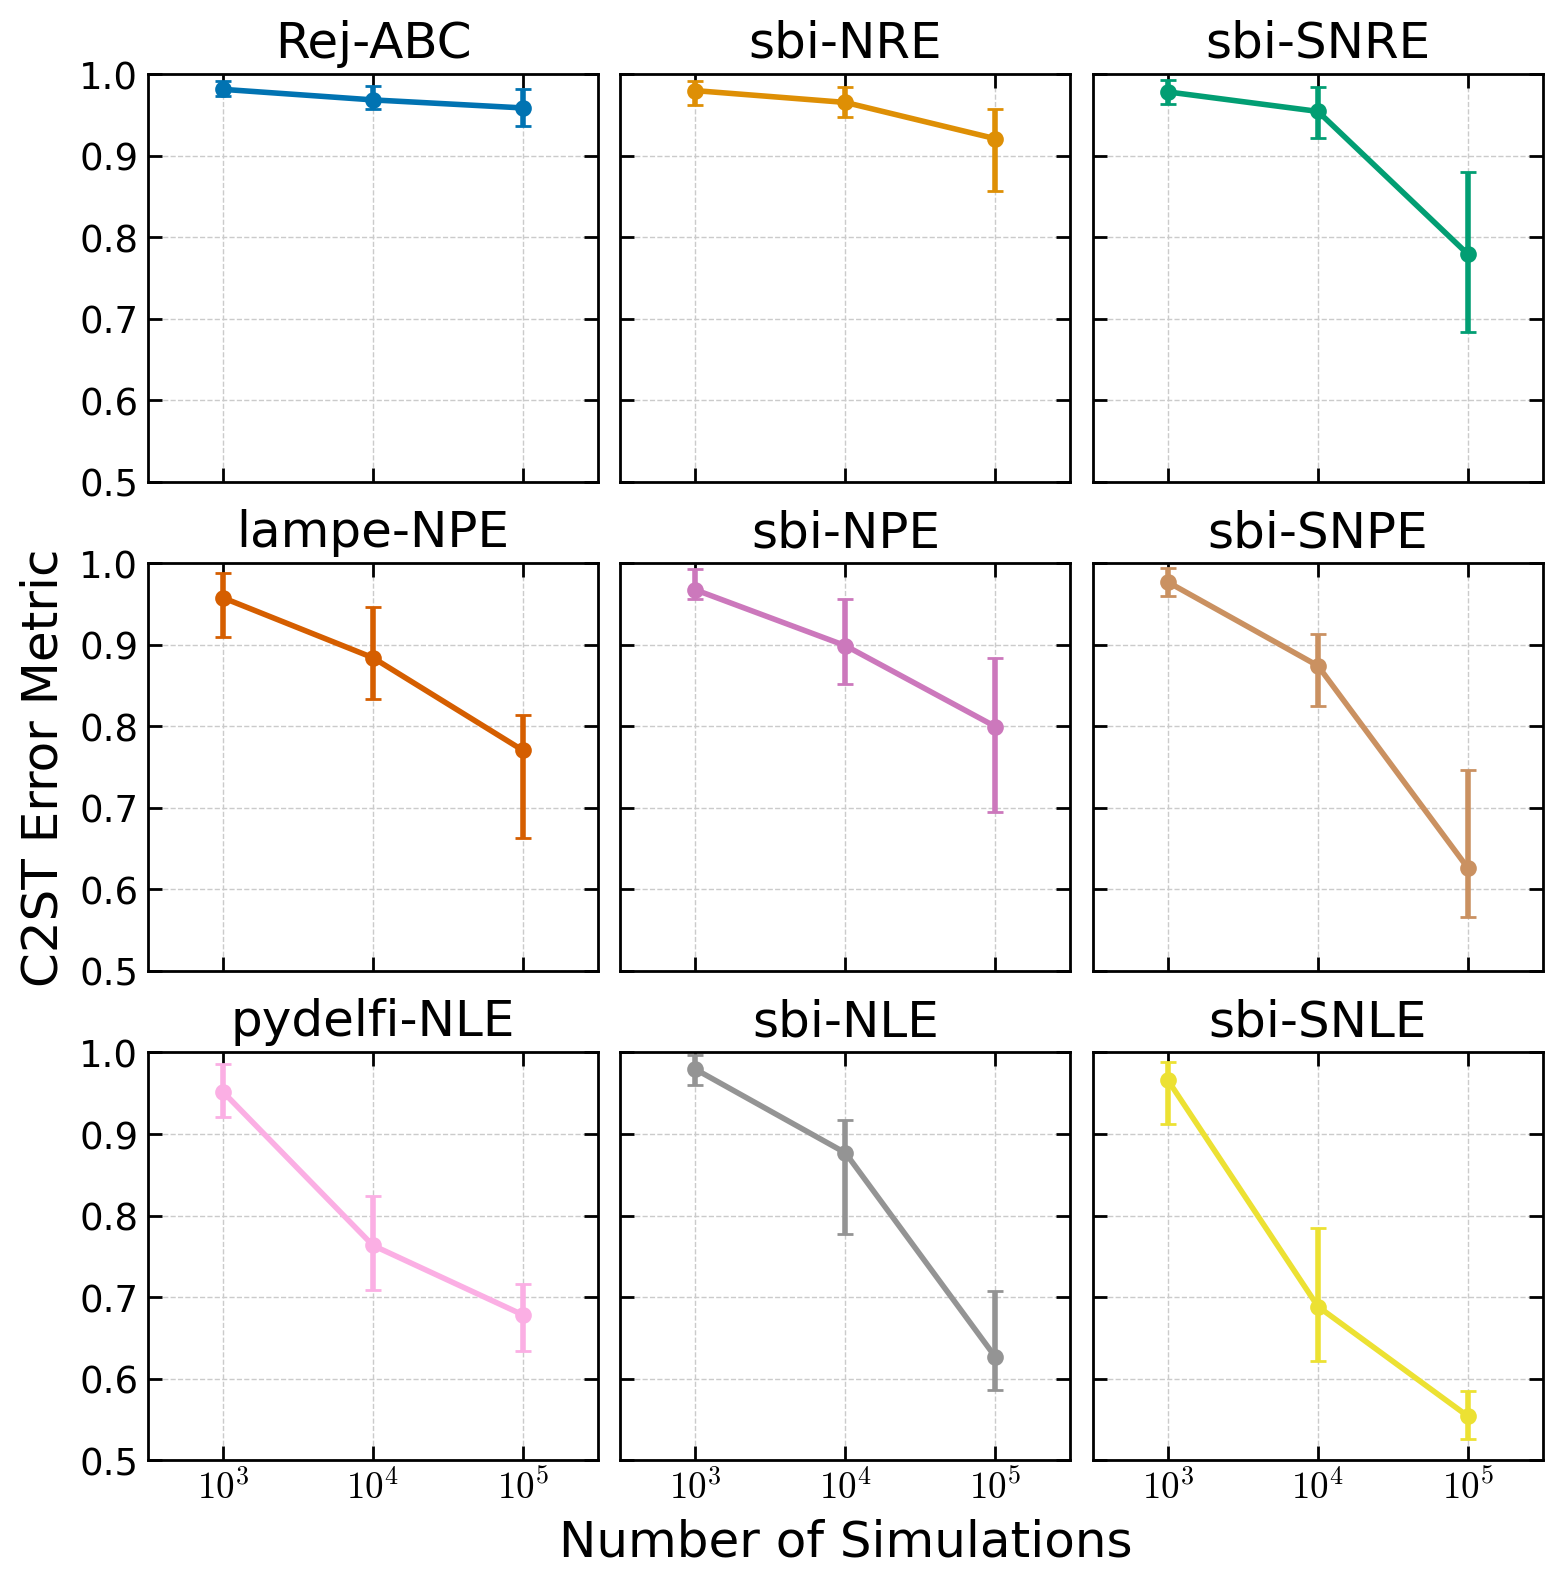

In [14]:
from math import ceil

keys = ['mcabc', 'nre', 'snre',
        'lampe', 'npe', 'snpe', 
        'pydelfi', 'nle', 'snle']
names = ['Rej-ABC', 'sbi-NRE', 'sbi-SNRE', 
         'lampe-NPE', 'sbi-NPE','sbi-SNPE', 
         'pydelfi-NLE', 'sbi-NLE', 'sbi-SNLE']
cs = sns.color_palette('colorblind', n_colors=len(keys))

N = len(keys)
Ncol = 3
Nrow = ceil(N/Ncol)
f, axs = plt.subplots(Nrow, Ncol, figsize=(Ncol*3, Nrow*3),
                      sharex=True, sharey=True, 
                      gridspec_kw={'hspace':0.2, 'wspace':0.05})
axs = axs.flatten()

for i, m in enumerate(keys):
    ax = axs[i]
    p = np.stack(percs.loc[m].values)
    ax.errorbar(
        x=range(len(p)),
        y=p[:,1],
        yerr=[p[:,1]-p[:,0], p[:,2]-p[:,1]],
        fmt='o-',
        color=cs[i],
        capsize=3,
        markersize=5,
    )
    ax.set_title(names[i], fontsize=18)
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(0.5, 1)
    ax.set_xticks(range(3), [f"$10^{i}$" for i in range(3,6)])
    ax.minorticks_off()
    
    if i == 3:
        ax.set_ylabel('C2ST Error Metric', fontsize=18)
    if i == N-2:
        ax.set_xlabel('Number of Simulations', fontsize=18)
# f.savefig('../images/benchmark.pdf', bbox_inches='tight')

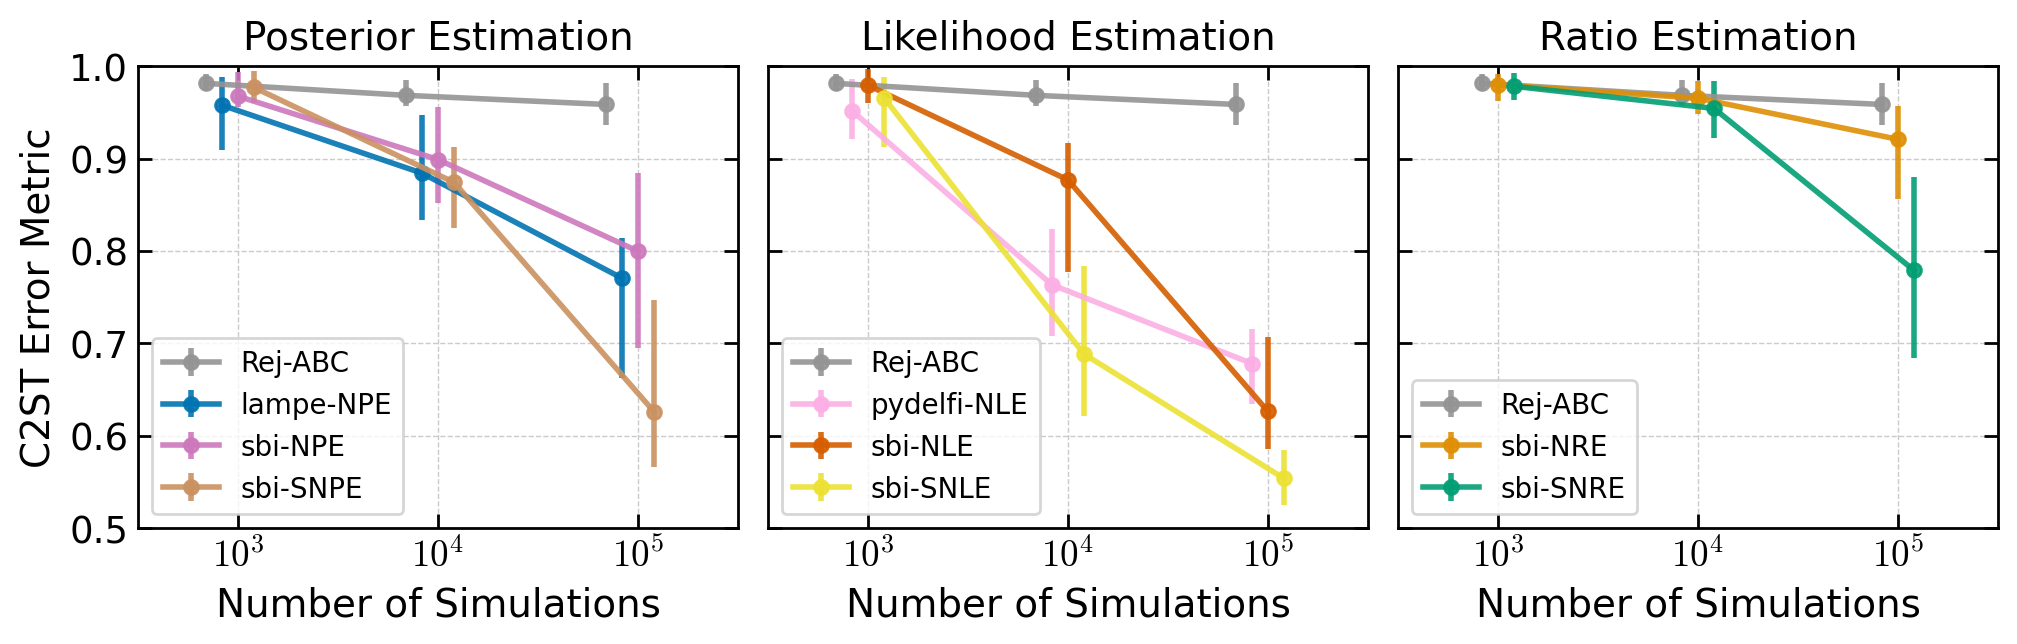

In [66]:
from math import ceil

keys = ['mcabc', 'nre', 'snre',
        'lampe', 'npe', 'snpe', 
        'pydelfi', 'nle', 'snle']
names = ['Rej-ABC', 'sbi-NRE', 'sbi-SNRE', 
         'lampe-NPE', 'sbi-NPE','sbi-SNPE', 
         'pydelfi-NLE', 'sbi-NLE', 'sbi-SNLE']
cs = sns.color_palette('colorblind', n_colors=len(keys))

name_map = dict(zip(keys, names))
color_map = dict(zip(keys, cs))

# swap colors so ABC is gray
c = color_map['lampe']
color_map['lampe'] = color_map['mcabc']
color_map['mcabc'] = color_map['nle']
color_map['nle'] = c

N = len(keys)
Ncol = 3
Nrow = 1
f, axs = plt.subplots(Nrow, Ncol, figsize=(Ncol*4, Nrow*3),
                      sharex=False, sharey=True, 
                      gridspec_kw={'hspace':0.25, 'wspace':0.05})
axs = axs.flatten()

def plot_subplot(ax, keys):
    offset = 0.08
    off_0 = len(keys) // 2 
    for i, m in enumerate(keys):
        off = (i - off_0) * offset

        p = np.stack(percs.loc[m].values)
        ax.errorbar(
            x=np.arange(len(p))+off,
            y=p[:,1],
            yerr=[p[:,1]-p[:,0], p[:,2]-p[:,1]],
            fmt='o-',
            color=color_map[m],
            # capsize=3,
            markersize=5,
            label=name_map[m],
            alpha=0.9
        )
        ax.set_xlim(-0.5, 2.5)
        ax.set_ylim(0.5, 1)
        ax.set_xticks(range(3), [f"$10^{i}$" for i in range(3,6)])
        ax.minorticks_off()
        ax.grid(True)
        ax.legend(loc='center left', fontsize=10)
        ax.set_xlabel('Number of Simulations', fontsize=14)
    
ax = axs[0]
plot_subplot(ax, ['mcabc', 'lampe', 'npe', 'snpe'])
ax.set_title('Posterior Estimation', fontsize=14)
ax.set_ylabel('C2ST Error Metric', fontsize=14)

ax = axs[1]
plot_subplot(ax, ['mcabc', 'pydelfi', 'nle', 'snle'])
ax.set_title('Likelihood Estimation', fontsize=14)

ax = axs[2]
plot_subplot(ax, ['mcabc', 'nre', 'snre'])
ax.set_title('Ratio Estimation', fontsize=14)

# axs[-1].axis('off')
f.savefig('../images/benchmark.pdf', bbox_inches='tight')

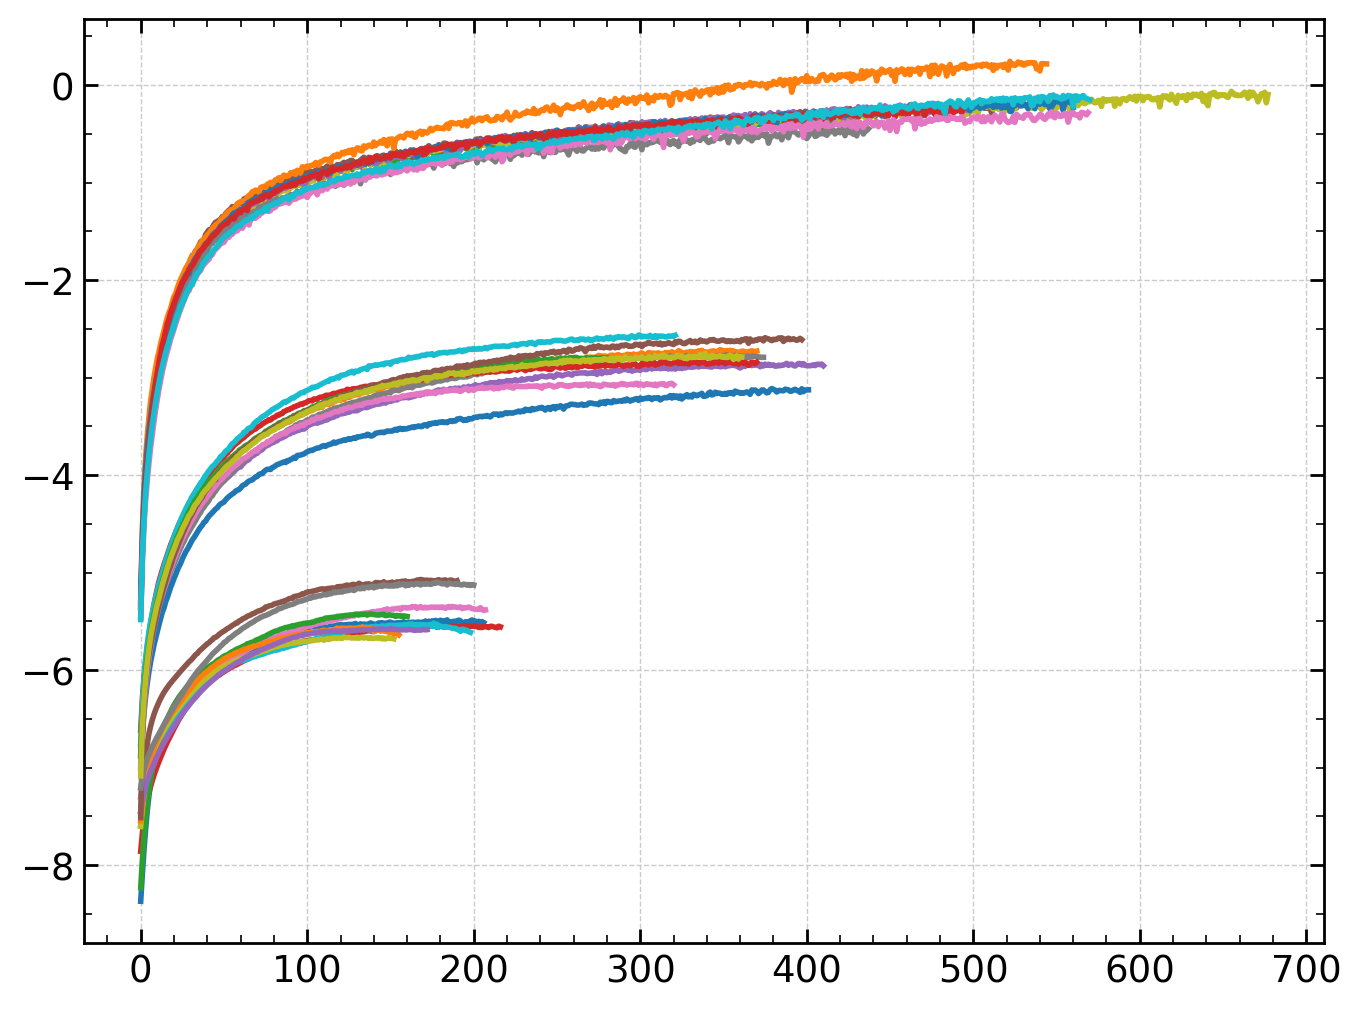

In [30]:
import json 

model = 'lampe'
for i, row in record.iterrows():
    if not row['done']:
        continue
    if row['model'] != model:
        continue
    summ =  json.load(open(join(row['dir'], 'summary.json')))[0]
    val_loss = summ['validation_log_probs']

    plt.plot(val_loss, label=f"{row['model']}_{row['N']}")
# plt.legend()

# Scratch